In [1]:
# import library
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import prince
from sklearn.decomposition import PCA

# pd.set_option('display.max_columns', None,'display.max_row', None)

In [2]:
# Stardust ver unique keyword search
def unique_keyword_search(df_col: pd.Series, num_selected: int) -> list:
    '''
    Performs unique keyword search on a dataframe's column for its most common keywords

    :param pd.Series df_col: column of a pd.DataFrame (e.g. df['col'])
    :param int num_selected: number of keywords
    :return: list of keywords in decreasing occurrence
    :rtype: list
    '''
    keywords = []
    for entry in df_col:
        words = entry.split(',')
        [keywords.append(word) for word in words]
    sorted_keywords = Counter(keywords).most_common()
    output_keywords = []
    for i in range(num_selected):
        output_keywords.append(sorted_keywords[i][0])
    return output_keywords

In [3]:
# Stardust ver one-hot encoder
def onehot_encoder(df: pd.DataFrame, col_name: str, num_selected: int) -> pd.DataFrame:
    '''
    Performs one-hot encoding on a dataframe's column for its values with most occurrences

    :param pd.DataFrame df: dataframe to be processed
    :param str col_name: name of the encoded column
    :param int num_selected: number of values with most occurrences
    :return: processed dataframe
    :rtype: pd.DataFrame
    '''
    series = df[col_name].value_counts()
    selected_col_name = series.head(num_selected).index.tolist()

    for item in selected_col_name:
        df[col_name + "_" + item] = np.where(df[col_name] == item, 1, 0) # whenever df[col_name] == cat replace it with 1 else 0
        
    df.drop(columns=col_name, inplace=True)
    return df

In [4]:
# Stardust ver one-hot encoder V2
def onehot_encoder_v2(df: pd.DataFrame, col_name: str, list_selected: list) -> pd.DataFrame:
    '''
    Performs one-hot encoding on a dataframe's column for its values with most occurrences

    :param pd.DataFrame df: dataframe to be processed
    :param str col_name: name of the encoded column
    :param list list_selected: list of most common values
    :return: processed dataframe
    :rtype: pd.DataFrame
    '''
    for item in list_selected:
        df[item] = np.where(df[col_name] == item, 1, 0) # whenever df[col_name] == cat replace it with 1 else 0
    df.drop(col_name, axis=1, inplace=True)

    return df

In [5]:
# read the CSV
df = pd.read_csv("organizations.csv")
# change the cols to keep
keep_col = ['category_list','founded_on']
df = df[keep_col]

In [6]:
df.dropna(subset=['category_list'], inplace=True)

In [7]:
# filter by founding date: keep companies founded on or after 2010-1-1
start_date = "2010-1-1"
after_start_date = df["founded_on"] >= start_date
df = df.loc[after_start_date]

In [8]:
keep_col = ['category_list']
df = df[keep_col]

In [9]:
# # view distinct values
# cat_list_series = df['category_list'].value_counts()
# print(cat_list_series)
# result: too many strings with commas, use unique_keyword_search()

In [10]:
# filter by industry: keep fintech companies
# keywords are obtained by inspecting the series from value_counts()
fintech_primary_keywords = ['Finance', 'Financial Services', 'FinTech', 'Personal Finance', 'Financial Exchanges', 'Bitcoin', 'Blockchain', 'Cryptocurrency', 'Payments']
# df.dropna(axis=0, subset=['category_list'], inplace=True)
# categories can be formed from one or more above elementary keywords
df = df[df['category_list'].str.contains('|'.join(fintech_primary_keywords))]

In [11]:
# find the fintech keywords
num_keywords = 150
fintech_keywords = unique_keyword_search(df['category_list'], num_keywords)

In [12]:
print(len(fintech_keywords))

150


In [13]:
print(fintech_keywords)

['Financial Services', 'FinTech', 'Finance', 'Blockchain', 'Information Technology', 'Software', 'Payments', 'Cryptocurrency', 'Venture Capital', 'Internet', 'Banking', 'Consulting', 'Mobile Payments', 'E-Commerce', 'Insurance', 'Bitcoin', 'Artificial Intelligence', 'Mobile', 'Crowdfunding', 'SaaS', 'Real Estate', 'Apps', 'Personal Finance', 'Accounting', 'Mobile Apps', 'Asset Management', 'Marketplace', 'Lending', 'Big Data', 'Machine Learning', 'Education', 'Analytics', 'Health Care', 'Wealth Management', 'Financial Exchanges', 'Trading Platform', 'Information Services', 'Enterprise Software', 'Business Development', 'Angel Investment', 'B2B', 'Internet of Things', 'Credit', 'Impact Investing', 'InsurTech', 'Small and Medium Businesses', 'Marketing', 'Advice', 'Real Estate Investment', 'Cyber Security', 'Security', 'Legal', 'Social Media', 'Communities', 'Ethereum', 'Retail', 'Risk Management', 'Management Consulting', 'Advertising', 'News', 'Credit Cards', 'Automotive', 'Human Resou

In [14]:
onehot_encoder_v2(df, 'category_list', fintech_keywords)
categorical_features = list(df.columns.values)[1:]

In [15]:
# heatmap to show correlation
# plt.figure(figsize=(20,20))
# sns.set(style="whitegrid")
# sns.heatmap(df[numerical_features].corr(method='pearson'), vmin=-.1, vmax=1,  annot=True)
# plt.show()

In [16]:
pca = prince.PCA(
     n_components=10,
     n_iter=10,
     rescale_with_mean=False,
     rescale_with_std=False,
     copy=True,
     check_input=True,
     engine='sklearn',
     random_state=0
 )
pca = pca.fit(df[categorical_features])

In [17]:
print(pca.eigenvalues_)

[0.01656003 0.0103769  0.00666703 0.0030378  0.00204312 0.00107533
 0.00094091 0.00069896 0.00029571 0.        ]


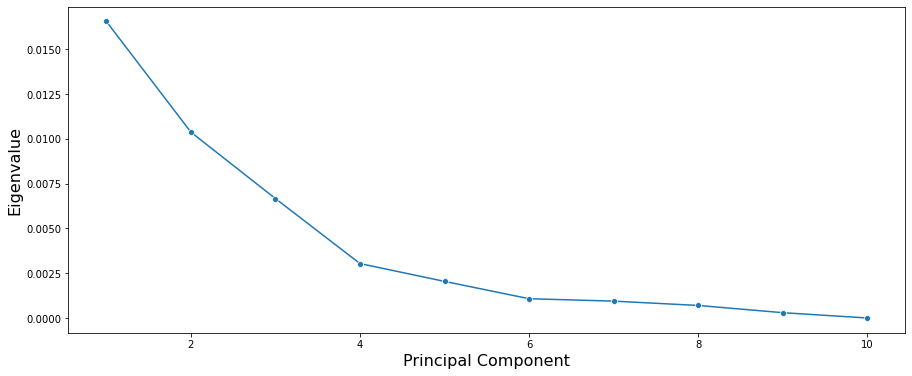

In [18]:
dset = pd.DataFrame()
dset['pca'] = range(1,11)
dset['eigenvalue'] = pd.DataFrame(pca.eigenvalues_)
plt.figure(figsize=(15,6))
sns.lineplot(x='pca', y='eigenvalue', marker="o", data=dset)
plt.ylabel('Eigenvalue', fontsize=16)
plt.xlabel('Principal Component', fontsize=16)
plt.show()

In [19]:
print(pca.explained_inertia_)
print("The first 5 components retain:")
print(pca.explained_inertia_[:5].sum())
print("of the original pattern")
# conclusion: use the first 5 components

[0.39716312 0.2488717  0.15989684 0.07285622 0.04900064 0.02578981
 0.02256609 0.01676338 0.0070922  0.        ]
The first 5 components retain:
0.9277885235332047
of the original pattern


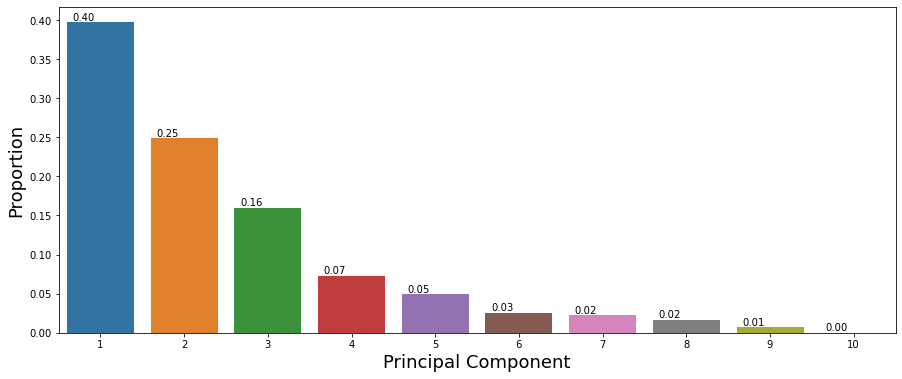

In [20]:
dset = pd.DataFrame()
dset['pca'] = range(1,11)
dset['vari'] = pd.DataFrame(pca.explained_inertia_)

plt.figure(figsize=(15,6))
graph = sns.barplot(x='pca', y='vari', data=dset)
for p in graph.patches:
    graph.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()),
                   ha='center', va='bottom',
                   color= 'black')
plt.ylabel('Proportion', fontsize=18)
plt.xlabel('Principal Component', fontsize=18)
plt.show()

In [21]:
# pca.column_correlations(df[categorical_features]).head(60)

In [22]:
# choose the first 5 components
# can print head for observation
cat_pca_df = pca.transform(df[categorical_features])

In [23]:
cat_pca_df.head()

,0,1,2,3,4,5,6,7,8,9
384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
cat_pca_df.info()
print(cat_pca_df.max())
print(cat_pca_df.min())
print(cat_pca_df.sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37198 entries, 384 to 1230948
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       37198 non-null  float64
 1   1       37198 non-null  float64
 2   2       37198 non-null  float64
 3   3       37198 non-null  float64
 4   4       37198 non-null  float64
 5   5       37198 non-null  float64
 6   6       37198 non-null  float64
 7   7       37198 non-null  float64
 8   8       37198 non-null  float64
 9   9       37198 non-null  float64
dtypes: float64(10)
memory usage: 3.1 MB
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    0.0
dtype: float64
0   -1.535563e-26
1   -4.440892e-16
2   -6.511989e-18
3   -4.143685e-18
4   -6.249101e-19
5   -1.110223e-16
6   -3.793608e-16
7   -1.880325e-16
8   -1.499014e-26
9    0.000000e+00
dtype: float64
0    616.0
1    386.0
2    248.0
3    113.0
4     76.0
5     40.0
6     35.0
7     26.0
8     11.0
9  

In [25]:
# this cell takes 1-2 mins to run, as there are 150 one-hotted cols
num_components_chosen = 5
cat_pca_df = cat_pca_df.iloc[:, 0:num_components_chosen]
cat_pca_df.add_prefix('cat_pca_')
df = df.join(cat_pca_df)
df.drop(columns=categorical_features, inplace=True)
df.head()

,Financial Services,0,1,2,3,4
384,0,0.0,0.0,0.0,0.0,0.0
1168,0,0.0,0.0,0.0,0.0,0.0
1179,0,0.0,0.0,0.0,0.0,0.0
1785,0,0.0,0.0,0.0,0.0,0.0
2029,0,0.0,0.0,0.0,0.0,0.0


In [26]:
# keywords = []
# for entry in df['category_list']:
#     words = entry.split(',')
#     [keywords.append(word) for word in words]
# sorted_keywords = Counter(keywords).most_common()[:10]

In [27]:
# # by trial and error, top 70 keywords cover 795597 / 1225334 = 0.649 of all category_list values
# # sorted_keywords[:50]
# total = 0
# for i in range(len(sorted_keywords)):
#     total += sorted_keywords[i][1]

# keyword_count = np.empty(0)
# s = 0
# for i in range(len(sorted_keywords)):
#     s += sorted_keywords[i][1]
#     keyword_count = np.append(keyword_count, s)
# keyword_ratio = keyword_count / total

In [28]:
# fig, ax = plt.subplots()

# ax.plot(np.arange(len(sorted_keywords)), keyword_ratio, '-')

# ax.set_title('Ratio of keywords against number of keywords')
# ax.grid()
# plt.show()

In [29]:
df.reset_index(inplace=True)
df.drop(axis=1, labels='index', inplace=True)

In [30]:
# df.to_csv("organizations_cleaned.csv", index=False)